<img src='https://github.com/LinkedEarth/Logos/blob/master/Pyleoclim/PYLEOCLIM_logo_HORZ-01.png?raw=true' width="800">

# Correlation Analysis in Pyleoclim

by  [Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)

## Preamble

This tutorial has two parts, highlighting two important applications of correlation analysis to paleoclimatology.
1. The first tackles the comparison of age-uncertain records, and is inspired by a similar one in Pyleoclim's sister package, [GeoChronR](https://nickmckay.github.io/GeoChronR/articles/correlation.html).
2. The second shows how to compute correlations between a record and a gridded field, illustrative of the [multiple comparisons (aka "Look Elsewhere") effect](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). 

We also show how the latest `Pyleoclim` version can apply different types of surrogates for significance testing, and compute different metrics of association, from the usual Pearson correlation to more exotic statistics like
Spearman’s $\rho$ or Kendall's $\tau$, which sidestep the assumption of a linear relationship between series. 


### Goals:

* load and create age ensemble data
* run correlation workflow on those ensembles, using various statistics and surrogates
* interpret the results of these correlation tests, especially when [multiple tests are carried out at once](https://en.wikipedia.org/wiki/Multiple_comparisons_problem)
* go between `LiPD`-formatted paleo data and `Xarray` datasets, using `pandas` and `Pyleoclim` as go-betweens


**Reading Time:**

10 minutes

### Keywords

Age ensembles, Surogates, multiple hypotheses, serial correlation, significance

### Pre-requisites

None. This tutorial assumes basic knowledge of Python. If you are not familiar with this coding language, check out this tutorial: [http://linked.earth/LeapFROGS/](http://linked.earth/LeapFROGS/).

### Relevant Packages

Pickle, Pyleoclim

## Data Description

- Hulu Cave record: https://www.science.org/doi/10.1126/science.1064618
- GISP2: https://icecores.org/inventory/gisp2
- ERSSTv5: [Huang et al, (2017)](https://10.1175/JCLI-D-16-0836.1)
- Palmyra modern Sr/Ca data: [Nurhati et al (2011)](https://doi.org/10.1175/2011JCLI3852.1)

Let's import the packages needed for this tutorial:

In [1]:
%load_ext watermark
import pickle
import pyleoclim as pyleo

### Age-uncertain Correlations
This example compares two high-resolution paleoclimate records with quantifiable age uncertainties: the Hulu Cave speleothem record of [Wang et al. (2001)](https://www.science.org/doi/10.1126/science.1064618) and the [GISP2](https://icecores.org/inventory/gisp2) ice core record. Both measure stable oxygen isotopes ($\delta^{18} \mathrm{O}$), though these proxy systems have radically different interpretations, which are not relevant here. 

On multi-millennial timescales, the two datasets display such similar features that the well-dated Hulu Cave record has been used to argue for atmospheric teleconnections between the regions and support the independent chronology of GISP2. In this example, we revisit this relation quantitatively and use their age models (one provided, one created using a built-in `Pyleoclim` function), to calculate the impact of age uncertainty on the correlation between these two iconic datasets. 

First, let's look at the Hulu Cave dataset from [Wang et al. (2001)](https://www.science.org/doi/10.1126/science.1064618), with age ensemble generates using [BChron](https://doi.org/10.1111/j.1467-9876.2008.00623.x):

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='d18O [permil]'>)

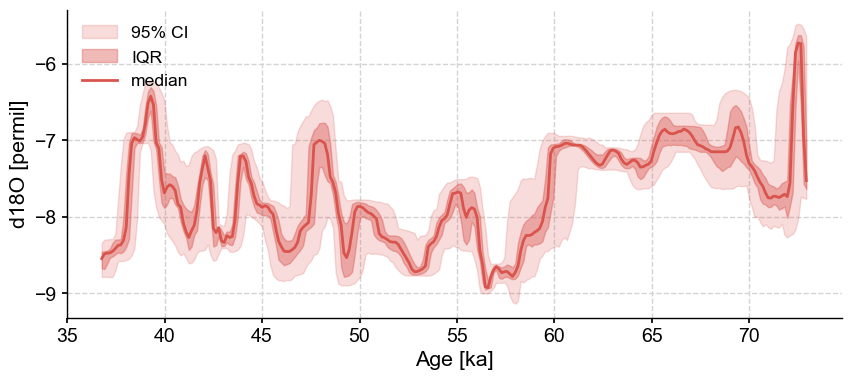

In [2]:
with open('../data/hulu_ensemble.pkl','rb') as handle:
    Hulu = pickle.load(handle)
Hulu.label = 'Hulu Cave'
Hulu.value_name = r'$\delta^{18} \mathrm{O}$'
Hulu.value_unit = '‰'
Hulu = Hulu.convert_time_unit('ky BP')
Hulu.common_time().plot_envelope()

Next we load GISP2, which actually ships with `Pyleoclim` (see [this tutorial](L0_loading_to_series.md)). Its original time unit is "years BP", which we convert to "ky BP" (thousands of years before present) to harmonize with Hulu:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>)

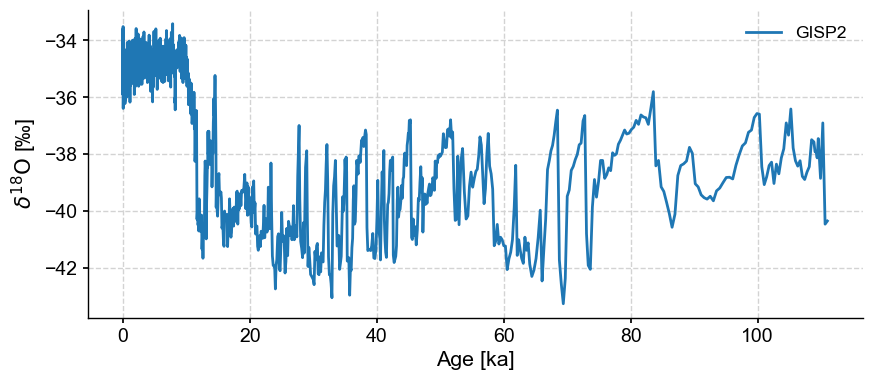

In [3]:
GISP2 = pyleo.utils.load_dataset('GISP2')
GISP2 = GISP2.convert_time_unit('ky BP')
GISP2.plot()

### Create age ensemble
Hulu already has an age ensemble, but GISP2 doesn't. To generate a plausible one, we use a Pyleoclim function called [random_time_axis](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsmodel.random_time_axis) to create a 1000-member [EnsembleSeries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#ensembleseries-pyleoclim-ensembleseries) object with time perturbations of $\pm100y$ with a 2% probability:

In [4]:
nEns = 1000
n = len(GISP2.time)
slist = []
for _ in range(nEns):
    pert = pyleo.utils.tsmodel.random_time_axis(n,
                                         delta_t_dist='random_choice',
                                         param =[[-0.1,0,0.1],[0.02,0.96,0.02]])
    ts = GISP2.copy()
    ts.time = GISP2.time + pert
    slist.append(ts)
GISP2e = pyleo.EnsembleSeries(slist)

Notice how we specified parameters here: `param =[[-0.1,0,0.1],[0.02,0.96,0.02]]` means that the time increment perturbations (departures from 1), are rare and symmetric, being 0ky 96% of the time, and $\pm0.1$ky the remaining 4\% of the time. Let us plot the result: 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='$\\delta^{18} \\mathrm{O}$ [‰]'>)

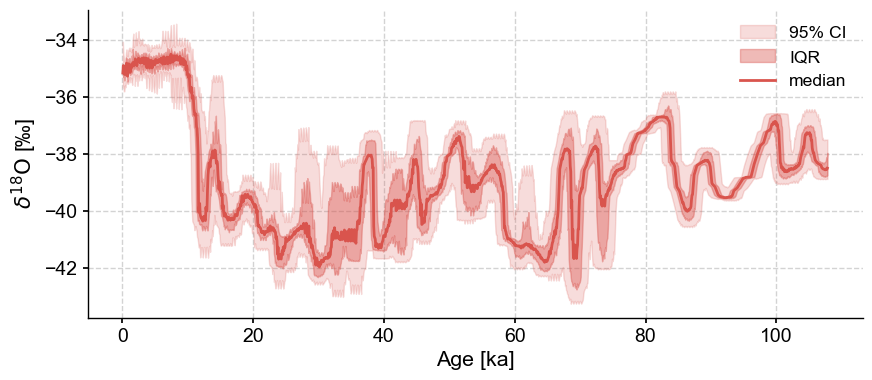

In [5]:
GISP2e.common_time().plot_envelope()

## Correlating the medians
Before delving into the ensembles, let's extract their medians and explore their correlation, to showcase a few of `Pyleoclim`'s capabilities. The default measure of association is Pearson's product-moment correlation, more commonly known as [Pearson's R](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). However, there are several ways of assessing the significance of the result. We use 3 here:
- the [built-in test from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)
- a Monte Carlo simulation using [AR(1) surrogates](L1_surrogates.md).
- a Monte Carlo simulation using [phase-randomized surrogates](L1_surrogates.md)

### Effect of persistence

In [8]:
Hulu_m = Hulu.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
GISP2_m = GISP2e.common_time().quantiles(qs=[0.5]).series_list[0] # this turns it into a Series
for method in ['built-in','ar1sim','phaseran',]:
    corr_m = Hulu_m.correlation(GISP2_m,method=method)
    print(corr_m)

  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.395784               nan  < 1e-13    True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1523.52it/s]


  statistic    critical value    p-value  signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.395784         -0.507637       0.23  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1618.51it/s]

  statistic    critical value    p-value  signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.395784         -0.369923        0.1  False



In [7]:
type(corr_m)

pyleoclim.core.corr.Corr

The result of these calculations is stored in a [Corr object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#corr-pyleoclim-corr), which contains several things:
- `r` (float), the statistic measuring association
- `r_crit` (float), the critical value of this statistic (i.e. the threshold value that must be exceeded (in absolute value) to call this "significant"). This is provided as a convenience for some applications, and cannot be computed in all cases (e.g. the `built-in` method)
- `p` (float),  the p-value, which is used to decide whether the correlation is in any way remarkable ("significant")
- `signif`, a boolean indicating whether significance was reached, at the indicated level (0.05 by default)

We see that the three methods return the same value $r \approx -0.4$ but quite different assessments of the [$p$-value](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5187603/):
- the __built-in test__, which assumes that the data are Gaussian and [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), suggests a _highly_ significant result, with a p-value less than $10^{-13}$.
- the test against both surrogates suggests the correlation is _not significant_ at the 95\% level.

This is a reminder of the importance of judiciously applying statistical tests in the paleo context. As recounted by [Hu et al (2017)](http://dx.doi.org/10.1016/j.epsl.2016.11.048), there are 3 major pitfalls for paleo-correlations. The first, which is here on full display, is that __serial correlation__ (persistence) undermines the assumption that consecutive samples are independent, thereby radically reducing the number of degrees of freedom available to the test. This can often invalidate such tests entirely. Accordingly, `Pyleoclim` implements a modified version of the built-in test, which estimates the effective degrees of freedom $n_\mathrm{eff}$ lost to serial correlation. This method is available as `ttest`, but in this case it would not work because it results in $n_\mathrm{eff}<10$, which is too small for this test to make any sense (try it!).

### Effect of nonlinearity

Now we showcase how to apply a different statistic, for example, Spearman's $\rho$ and Kendall's $\tau$:

In [20]:
for method in ['built-in','ar1sim','phaseran']:
    corr_s = Hulu_m.correlation(GISP2_m,statistic='spearmanr',method=method)
    print(corr_s)

  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.396495               nan  < 1e-13    True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1016.97it/s]


  statistic    critical value    p-value  signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.396495         -0.515154        0.2  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1023.54it/s]

  statistic    critical value    p-value  signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.396495          -0.37607       0.07  False



Same for Kendall's $\tau$:

In [9]:
for method in ['built-in','ar1sim','phaseran']:
    corr_t = Hulu_m.correlation(GISP2_m,statistic='kendalltau',method=method)
    print(corr_t)

  correlation  p-value    signif. (α: 0.05)
-------------  ---------  -------------------
    -0.263541  < 1e-12    True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 2598.87it/s]


  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    -0.263541       0.23  False



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 2885.02it/s]

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
    -0.263541       0.08  False



We see that Spearman's $\rho$ yields results very close to Pearson's $r$ (the phase randomization test is now at the edge of significance), so nonlinearity is probably not a main concern. Quantitatively, Kendall's $\tau$ estimates a lower absolute correlation, but assessments of significance are the same as before: the built-in test suggests a highly significant correlation, a result contradicted by the surrogates.  All in all, a reasonable investigator would dismiss this correlation between median age models as non significant. 

#### Multiple Comparison

We now tackle the  [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem), which can create the appearance of significant results because, at the 5% level, 5% of tests will return a false positive, so if thousands of comparisons are carried out (as is the case here), then one expects that a few dozen of them will be identified as "significant" at that level ($\alpha=0.05$). A solution to this problem was worked out in 1995 as the [false-discovery rate](https://en.wikipedia.org/wiki/False_discovery_rate) procedure (FDR), which is implemented in `Pyleoclim`.

The latter can carry out correlations between `EnsembleSeries` objects, and here the result has more features. This calculation, using 1000 surrogates for each of the 1000 age models, computes a million correlations, and therefore takes a few minutes:

In [10]:
corr_e = Hulu.correlation(GISP2e, method='phaseran',number=1000)

Looping over 1000 Series in the ensemble


  0%|          | 0/1000 [00:00<?, ?it/s]

Time axis values sorted in ascending order


100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='$r$', ylabel='Count'>)

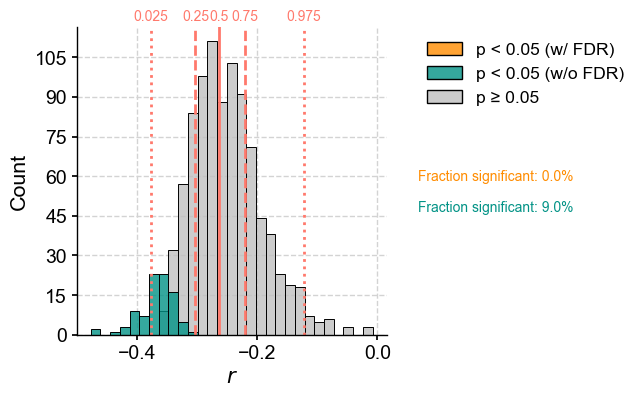

In [11]:
corr_e.plot()

In [12]:
type(corr_e)

pyleoclim.core.correns.CorrEns

Whereas the previous correlation results were stored in a `Corr` object, this one is stored in a [CorrEns object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#correns-pyleoclim-correns). It contains very similar information to `Corr`, but the lists can be tedious to inspect in print, so a visual inspection via its `plot()` method (see figure above) is far more useful.

It shows that :
- the vast majority of correlations between individual ensemble members are judged non-significant.
- a subset of those (around 9%) are found significant. However, when accounting for the multiple comparisons problem via FDR, __none of them are found significant__.

This confirms what was found earlier using median age models. This is not always the case, as [the median (or mean) is often a very poor summary of a dataset](http://salavon.com/work/specialmoments/). When ensembles are available, it is always preferable to look at them in their entirety, something `Pyleoclim` makes practical.  

## Field Correlations
Another example of multiple comparison arises when assessing correlations between a single series (e.g. a paleoclimate record, or an instrumental station) and an instrumental climate [field](https://glossary.ametsoc.org/wiki/Field). Here, we use as our record the coral Sr/Ca series (a proxy for sea-surface temperature) from [Nurhati et al (2011)](https://doi.org/10.1175/2011JCLI3852.1). The data are from Palmyra Island in the tropical Pacific, at the edge of the NINO3.4 box (a popular measure of the state of El Niño Southern Oscillation). We compare it to the sea-surface temperature analysis of ERSSTv5 [(Huang et al, 2017)](https://10.1175/JCLI-D-16-0836.1).

To do so we leverage the wonderful [Xarray package](https://docs.xarray.dev/en/stable/index.html) to load the data directly from NCEI's servers so they never have to be explicitly downloaded (aka "lazy-loading"). We also make use of [pyLiPD](https://pylipd.readthedocs.io/en/latest/) and a few other packages. 

In [9]:
from pylipd.lipd import LiPD
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

D = LiPD()
D.load('../data/Ocn-Palmyra.Nurhati.2011.lpd')
timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)
df

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00, 28.56it/s]

Loaded..
Extracting timeseries from dataset: Ocn-Palmyra.Nurhati.2011 ...


,mode,time_id,studyName,originalDataURL,hasUrl,pub1_author,pub1_url,pub1_institution,pub1_urldate,pub1_citeKey,...,paleoData_values,paleoData_proxyObservationType,paleoData_sensorGenus,paleoData_useInGlobalTemperatureAnalysis,paleoData_notes,paleoData_sensorSpecies,paleoData_proxy,paleoData_compilation_nest,paleoData_interpretation,paleoData_inCompilation
0,paleoData,age,Nurhati2011_Palmyra,http://hurricane.ncdc.noaa.gov/pls/paleox/f?p=...,https://data.mint.isi.edu/files/lipd/Ocn-Palmy...,I.S. Nurhati,[https://www.ncdc.noaa.gov/paleo/study/8609],World Data Center for Paleoclimatology,2010.0,nurhati2010httpswwwncdcnoaagovpaleostudy8609Da...,...,"[1998.21, 1998.13, 1998.04, 1997.96, 1997.88, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,paleoData,age,Nurhati2011_Palmyra,http://hurricane.ncdc.noaa.gov/pls/paleox/f?p=...,https://data.mint.isi.edu/files/lipd/Ocn-Palmy...,I.S. Nurhati,[https://www.ncdc.noaa.gov/paleo/study/8609],World Data Center for Paleoclimatology,2010.0,nurhati2010httpswwwncdcnoaagovpaleostudy8609Da...,...,"[0.39, 0.35, 0.35, 0.35, 0.36, 0.22, 0.33, 0.3...",d18O,Porites,False,d18Osw (residuals calculated from coupled SrCa...,lutea,d18O,NaN,NaN,NaN
2,paleoData,age,Nurhati2011_Palmyra,http://hurricane.ncdc.noaa.gov/pls/paleox/f?p=...,https://data.mint.isi.edu/files/lipd/Ocn-Palmy...,I.S. Nurhati,[https://www.ncdc.noaa.gov/paleo/study/8609],World Data Center for Paleoclimatology,2010.0,nurhati2010httpswwwncdcnoaagovpaleostudy8609Da...,...,"[8.96, 8.9, 8.91, 8.94, 8.92, 8.89, 8.87, 8.81...",Sr/Ca,Porites,True,; paleoData_variableName changed - was origina...,lutea,Sr/Ca,"MNE, NJA","[{'scope': 'climate', 'direction': 'negative',...",Ocean2k_v1.0.0
3,paleoData,age,Nurhati2011_Palmyra,http://hurricane.ncdc.noaa.gov/pls/paleox/f?p=...,https://data.mint.isi.edu/files/lipd/Ocn-Palmy...,I.S. Nurhati,[https://www.ncdc.noaa.gov/paleo/study/8609],World Data Center for Paleoclimatology,2010.0,nurhati2010httpswwwncdcnoaagovpaleostudy8609Da...,...,"[1998.29, 1998.21, 1998.13, 1998.04, 1997.96, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,paleoData,age,Nurhati2011_Palmyra,http://hurricane.ncdc.noaa.gov/pls/paleox/f?p=...,https://data.mint.isi.edu/files/lipd/Ocn-Palmy...,I.S. Nurhati,[https://www.ncdc.noaa.gov/paleo/study/8609],World Data Center for Paleoclimatology,2010.0,nurhati2010httpswwwncdcnoaagovpaleostudy8609Da...,...,"[-5.41, -5.47, -5.49, -5.43, -5.48, -5.53, -5....",d18O,Porites,False,Duplicate of modern d18O record presented in C...,lutea,d18O,"MNE, NJA","[{'direction': 'negative', 'hasVariable': {'la...",NaN


Let's put the Sr/Ca data into a [GeoSeries object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.geoseries.GeoSeries) so we can easily plot it in space and time:

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='Sr/Ca [mmol/mol]'>)

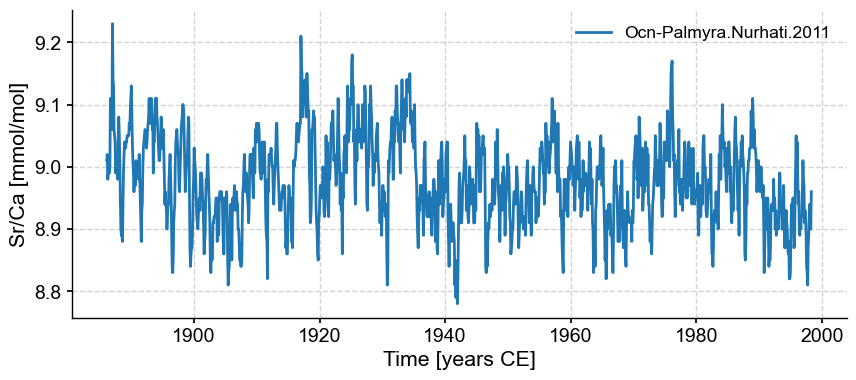

In [11]:
row = df[df['paleoData_variableName']=='Sr/Ca']

srca = pyleo.GeoSeries(
    time=row['year'].values[0],
    value=row['paleoData_values'].values[0],
    lon = df['geo_meanLon'][0],
    lat = df['geo_meanLat'][0],
    archiveType = 'coral',
    time_name = 'Time',
    time_unit = 'years CE',
    value_name = 'Sr/Ca',
    value_unit = row['paleoData_units'].values[0],
    label='Ocn-Palmyra.Nurhati.2011',
    auto_time_params = False,
) # load only the Sr/Ca observations
srca.plot()

(<Figure size 1800x700 with 1 Axes>,
 {'map': <GeoAxes: xlabel='lon', ylabel='lat'>})

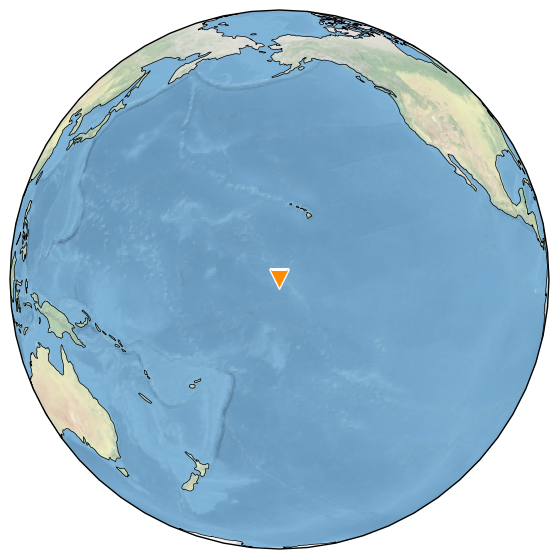

In [12]:
srca.map()

Palmyra Island sits in the very central Pacific, and we expect to see large-scale correlations with SST data.

Next we load the ERSSTv5 dataset. Note that the actual dat are not being transferred over the network yet; all we are getting is a pointer towards a netCDF file on a NOAA [THREDDS](https://docs.unidata.ucar.edu/tds/4.6/adminguide/) server. The real crunching will come later.

In [13]:
filepath = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ersstv5 = xr.open_dataset(filepath)
ersstv5

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2052, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-01-03
    DODS_EXTRA.Unlimited_Dimension:  time

The dataset has a $2^\circ \times 2^\circ$ resolution, which means a lot of grid points. Let us select a relatively narrow part of the Tropical Pacific:

In [14]:
ersstv5_tp = ersstv5.sel(lat=slice(15, -15), lon=slice(140, 280))
ersstv5_tp

<xarray.Dataset>
Dimensions:    (lat: 15, lon: 71, time: 2052, nbnds: 2)
Coordinates:
  * lat        (lat) float32 14.0 12.0 10.0 8.0 6.0 ... -8.0 -10.0 -12.0 -14.0
  * lon        (lon) float32 140.0 142.0 144.0 146.0 ... 274.0 276.0 278.0 280.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2025-01-03
    DODS_EXTRA.Unlimited_Dimension:  time

Let's plot the latest SST available in that domain:

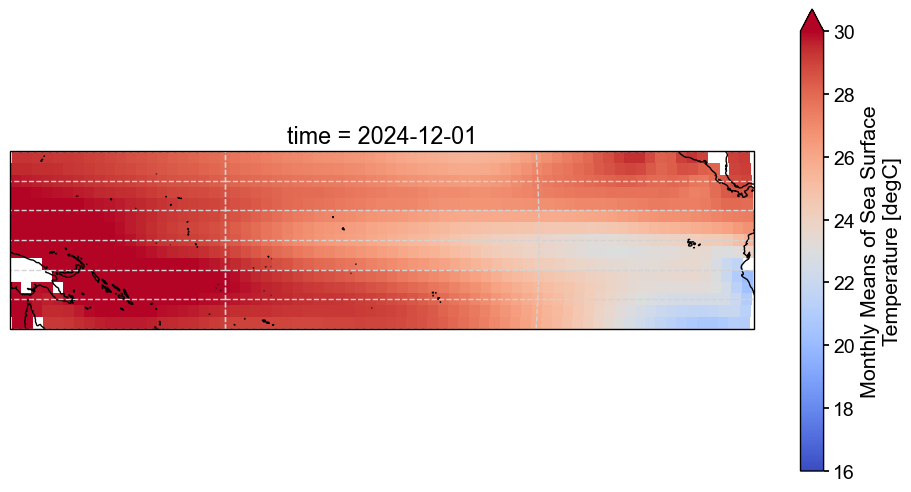

In [15]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ersstv5_tp.sst.isel(time=-1).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=16, vmax=30, cmap='coolwarm'
)

Let's remove the monthly-mean seasonal cycle (aka the "climatology") so that SST is expressed as anomalies around this cycle, as is the norm:

In [16]:
gb = ersstv5_tp.sst.groupby('time.month')
ersstv5_tpa = gb - gb.mean(dim='time')

Now extract the NINO3.4 index (a weighted average is involved, though it matters little so close to the equator because the weights are very close to unity):

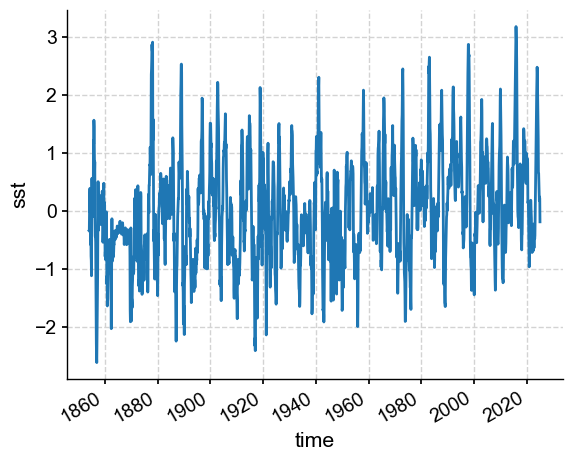

In [17]:
nino34_anom = ersstv5_tpa.sel(lat=slice(5, -5), lon=slice(190, 240))
weights = np.cos(np.deg2rad(nino34_anom.lat))
nino34 = nino34_anom.weighted(weights).mean(dim=['lat', 'lon'])
nino34.plot()

Now let's leverage [Pyleoclim's integration with pandas](https://medium.com/cyberpaleo/pandas-and-the-geosciences-a-4-5-billion-year-story-66af9f565a4b) to turn this into a Pyleoclim `Series` object. For this, we also leverage the fact that [Xarray is pandas-based](https://docs.xarray.dev/en/stable/user-guide/pandas.html). 

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Time [years CE]', ylabel='NINO3.4'>)

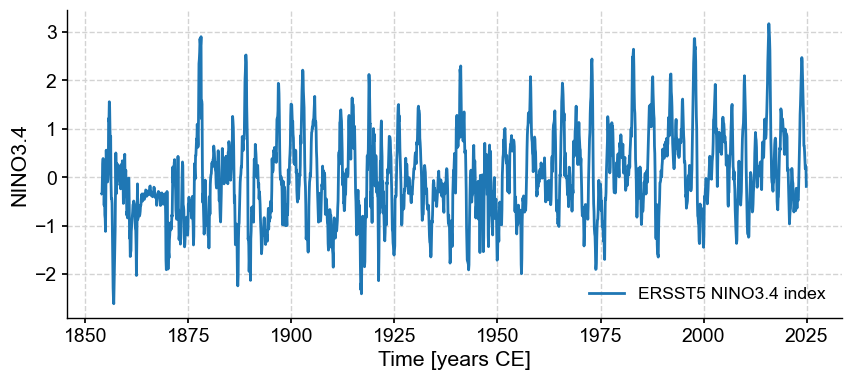

In [18]:
metadata = {
        'time_unit': 'years CE',
        'time_name': 'Time',
        'value_name': 'NINO3.4',
        'label': 'ERSST5 NINO3.4 index',
        'archiveType': 'Instrumental',
        'importedFrom': 'NOAA/NCEI',
    }

NINO34 = pyleo.Series.from_pandas(nino34.to_pandas(),metadata)
NINO34.plot()

Notice how easy that was! One line of code is all it took to export the `nino34` Xarray `DataArray` object as a pandas `Series`, and import it as a Pyleoclim `Series` (which is nothing more than a pandas `Series` with a little extra metadata to make life easier). Now we can deploy our correlation arsenal again, this time throwing in the T-test modified for the effects of serial correlation (`ttest`):

In [19]:
for method in ['built-in','ttest','ar1sim','phaseran']:
    corr_n = srca.correlation(NINO34,method=method)
    print(corr_n)

  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.453015               nan  < 1e-68    True

  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.453015           -0.1198  < 1e-3     True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:00<00:00, 1360.17it/s]


  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.453015         -0.143438  < 1e-6     True



Evaluating association on surrogate pairs: 100%|██████████| 1000/1000 [00:01<00:00, 967.01it/s]

  statistic    critical value  p-value    signif. (α: 0.05)
-----------  ----------------  ---------  -------------------
  -0.453015         -0.123136  < 1e-6     True



In this case, we see a correlation similar to what was observed between the Hulu and GISP2 records, but it appears **highly significant no matter what test is used**. 
The difference between the first two tests is instructive: we see how without accounting for serial correlation the p-value is a preposterous "<1e-68", meaning basically impossible. Once serial correlation is accounted for (admittedly crudely), we get a p-value near $10^{-3}$, which is quite a bit more conservative than those estimated with the Monte Carlo simulations (`ar1sim`,`phaseran`) near $10^{-6}$. Notably, the critical value of the statistic is comparable for all methods that calculate it.

We now wish to carry out a similar analysis over the SST grid, so we write a simple loop. For computational convenience, we restrict ourselves to the T-test, which requires no Monte Carlo simulations.  Notice how we use the same `pandas` trick as before as a cross-walk between `xarray` and `Pyleoclim`. 

In [21]:
nlon = ersstv5_tpa.lon.size
nlat = ersstv5_tpa.lat.size
metadata = {
        'time_unit': 'years CE',
        'time_name': 'Time',
        'value_name': 'SST',
        'label': 'ERSST5 local SST',
        'archiveType': 'Instrumental',
        'importedFrom': 'NOAA/NCEI',
    }
series_list = []
for ji in range(nlon):
    metadata['lon'] = ersstv5_tpa.lon.values[ji]
    for jj in range(nlat):
        local_sst = ersstv5_tpa.isel(lon=ji,lat=jj)
        # check for land points
        if ~np.isnan(local_sst.values.mean()):
            metadata['lat'] = ersstv5_tpa.lat.values[jj]
            series = pyleo.GeoSeries.from_pandas(local_sst.to_pandas(),metadata)
            series_list.append(series)
            
print(len(series_list))        
sst_ms = pyleo.MultipleGeoSeries(series_list) 

1051


There over 1000 series in this collection, but the syntax is the same: we simply apply the `correlation()` method, and plot the result as we did for the Hulu and GISP2 ensemble correlation above:

Looping over 1051 Series in collection


100%|██████████| 1051/1051 [09:14<00:00,  1.90it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='$r$', ylabel='Count'>)

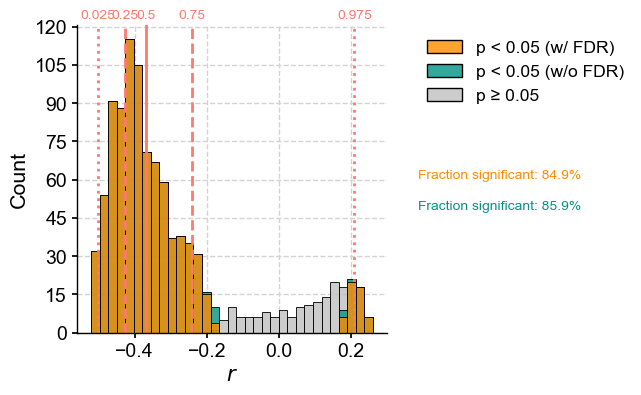

In [22]:
corr_f = sst_ms.correlation(srca,method='ttest')
corr_f.plot()

We see a bimodal distribution, with correlations close to 0 rejected as insignificant. In this case, the False Discovery Rate correction is very small, only changing the number of gridpoints significantly correlated to the Palmyra Sr/Ca record from 84.9% to 85.9%.

### Takeaways

- `pyleoclim` allows to easily compute correlations between series with different time axes (including different resolutions).

- `pyleoclim` assesses significance with 3 different methods that are meant to guard against the deleterious effects of persistence, thereby lowering the risk of spurious correlations and [p-hacking](https://youtu.be/42QuXLucH3Q). 

- `pyleoclim` allows to compute correlations between a series and a collection of series, e.g. coming from a gridded field, addressing the Multiple Hypothesis Problem with the False Discovery Rate. 

- `pyleoclim` allows to compute correlations between, and within, `MultipleSeries` and `EnsembleSeries` object, using those same tools. 

### Acknowledgments

Project Pythia for [this notebook](https://foundations.projectpythia.org/core/xarray/enso-xarray.html) on xarray manipulations

In [23]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 08 2025

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

cartopy   : 0.23.0
xarray    : 2023.6.0
numpy     : 1.26.4
pyleoclim : 1.1.0b0
matplotlib: 3.8.4

Watermark: 2.4.3

